In [25]:
import os
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from domid.arg_parser import mk_parser_main
from domid.mk_exp import mk_exp
from domid.models.model_ae import mk_ae
from domid.models.model_sdcn import mk_sdcn

os.chdir('../')
sys.path.insert(0,'/home/mariia.sidulova/domid_upgraded/DomId')
sys.path.insert(0, '/home/mariia.sidulova/domid_upgraded/DomId/DomainLab')

# print("Current working directory:", os.getcwd())


# Helper Functions

In [5]:

def get_most_recent_directory(directory):
    try:
        directories = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
        directories.sort(key=lambda x: os.path.getctime(os.path.join(directory, x)), reverse=True)
        return os.path.join(directory, directories[0])
    except Exception as e:
        print("Error:", e)
        return None



In [6]:
import pickle
def load_files(path):
    df = pd.read_csv(os.path.join(path, 'clustering_results.csv'))
    
    domain = df['predictions'].values
    
    vec_d = df['vec_d_labels'].values
    vec_y = df['vec_y_labels'].values
    img_locs = df['image_id_labels'].values

    Z = np.load(os.path.join(path, "Z_space.npy"))
    model_name = path.split('_')[-1]
    with open(os.path.join(path, 'commandline_arguments.p'), 'rb') as file:
        command_line = pickle.load(file)


    
    return domain, vec_d, vec_y, img_locs, model_name, command_line

In [7]:
def something_per_domain(domain, another_label):
    """
    domain - predicted domain labels 
    another_label - some other label that corresponds to each of the predicted domain (
    assumed that both domain and something have the same img_loc reference order 
    """
    u_something = np.unique(another_label)
    u_domain = np.unique(domain)
    print('unique predicted domain', u_domain)
    print('unique true label', u_something)
    
    array_counters=[]
    for i in u_domain:
        for j in u_something:
            counter = 0
            for idx in range(0, len(domain)):
                if domain[idx]==i and another_label[idx]==j:
                    counter+=1
            
            array_counters.append(counter)
    return array_counters

In [8]:
def plot_something_per_domain_proportion(domain, another_label, counts, fs, legend = False, thres = None, title = None, digit_plot = True):
    """
    domain - predicted domain labels
    another_label - another label aassociated with each predicted domain (should be same shape as domain)
    counts - countes of each another label in each of the predicted domain (see something_per_domain function)
    fs - font size
    colors - colors of each segment on the bargraph
    legend - legend of unique another lables
    thres - if thresholding of another label is required then should be shpecifies (also see apply_threshold function)
    
    """
    u_domains = np.unique(domain)
    N = len(u_domains)
    
    u_another_label = np.unique(another_label)
    print('unique labels', u_another_label)
    print(u_domains)
    counts = np.array(counts)
    narray = np.array_split(counts, N)

    if thres:
        u_another_label_dic = apply_threshold(u_another_label, narray, thres, N)
        #print(u_another_label_dic.values())
        u_another_label = list(u_another_label_dic.keys())
        narray = list(u_another_label_dic.values())
        narray = np.transpose(narray)

   # print(narray)
    #print(len(u_domains), len(u_another_label))
    # c = ['blue', 'teal', 'pink', 'orange', 'green', 'red', 'plum', 'grey', 'purple', 'yellow']
    # c = ['lightblue', 'steelblue', 'royalblue', 'mediumpurple', 'darkmagenta','orchid', 'lightpink', 'lightcoral', 'maroon', 'sandybrown']
    
    if digit_plot:
        c =  ['darkseagreen', 'forestgreen', 'aquamarine', 'lightseagreen', 'teal', 'steelblue','lightblue', 'royalblue','navy', 'lightslategrey' ]

    else:
        c = ['mediumpurple', 'darkmagenta','orchid', 'lightpink', 'lightcoral', 'maroon', 'sandybrown', 'peachpuff', 'goldenrod', 'gold']
  
        
    plt.figure(figsize = (5, 5))
    for i in range(0, len(u_domains)):
        for jj in range(0,len(u_another_label)):
            
            if jj>0:
                bottom = np.sum(narray[i][:jj])/np.sum(narray[i])
            else:
                bottom = 0
            ##print(i, narray[i][jj])
            #print(c[jj])
            plt.bar(i, narray[i][jj]/np.sum(narray[i]), bottom = bottom, color = c[jj])
    x = np.linspace(0, N-1, N)
    x_ticks = [str(item) for item in u_domains]
    #plt.ylabel("Proportion", fontsize=fs)
    plt.xticks(x, x_ticks, fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.xlabel("Domain", fontsize=fs)
    plt.title(title, fontsize = fs, weight = 'bold')
    plt.tick_params(left = False, labelleft = False)
    if legend:
        plt.legend(legend, bbox_to_anchor=(1, 1.1))
    else:
        plt.legend(u_another_label, bbox_to_anchor=(1, 1.1), fancybox=True, shadow=True, fontsize = fs)
    plt.show()

In [9]:

def get_last_created_directory(path):
    directories = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    directories.sort(key=lambda x: os.path.getctime(os.path.join(path, x)), reverse=True)
    if directories:
        return directories[0]
    else:
        return None


# VaDe Experiments with HER2 data

In [8]:
 # os.chdir('.')

In [13]:
# poetry run python main_out.py --te_d 0 --tr_d 0 1 2 
# --task=her2 --epos=15 --aname=vade --zd_dim=500 --d_dim=3 
# --apath=domid/algos/builder_vade.py --L=5 --pre_tr=4 --dpath "../../HER2/combined_train" --bs 4 --prior Gaus --model cnn --lr 0.000005

In [22]:
os.chdir('../')

In [17]:
exp = mk_exp(task='her2',model='vade',trainer='cluster', train_domain ="0 1 2", test_domain="0", batchsize="4",
             dpath= '../../HER2/combined_train/', zd_dim='500', model_method ='cnn',
            prior='Gaus', pre_tr='4', epos='15', d_dim='3',lr='0.000005')

The sets of training and test domains overlap -- be aware of data leakage or training to the test!


Namespace(config_file=None, lr=5e-06, gamma_reg=0.1, es=1, seed=0, nocu=True, device=None, gen=False, keep_model=False, epos=15, epos_min=0, epo_te=1, warmup=100, debug=False, dmem=False, no_dump=False, trainer='cluster', out='zoutput', dpath='../../HER2/combined_train/', tpath=None, npath=None, npath_dom=None, npath_argna2val=None, nname_argna2val=None, nname=None, nname_dom=None, apath=None, exptag='exptag', aggtag='aggtag', bm_dir=None, plot_data=None, outp_dir='zoutput/benchmarks/shell_benchmark', param_idx=True, msel='val', model='vade', acon=None, task='her2', bs=4, split=0, te_d=['0'], tr_d=['0', '1', '2'], san_check=False, san_num=8, loglevel='DEBUG', shuffling_off=False, zd_dim=500, zx_dim=0, zy_dim=64, topic_dim=3, nname_encoder_x2topic_h=None, npath_encoder_x2topic_h=None, nname_encoder_sandwich_x2h4zd=None, npath_encoder_sandwich_x2h4zd=None, gamma_y=None, gamma_d=None, beta_t=1.0, beta_d=1.0, beta_x=1.0, beta_y=1.0, tau=0.05, epos_per_match_update=5, epochs_ctr=1, nperm=31


using device: cpu

The sets of training and test domains overlap -- be aware of data leakage or training to the test!
/home/mariia.sidulova/domid_upgraded/DomId/DomainLab/domainlab/tasks/a_task.py:169: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(


ConvolutionalEncoder(
  (encod): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (mu_layer): Linear(in_features=2048, out_features=500, bias=True)
  (log_sigma2_layer): Linear(in_features=2048, out_features=500, bias=True)
)
ConvolutionalDecoder(
  (linear): Linear(in_features=500, out_features=2048, bias=True)
  (sigmoid_layer): Sigmoid()
  (unflat): UnFlatten()
  (decod)




!!!: not committed yet
/home/mariia.sidulova/domid_upgraded/DomId/DomainLab/domainlab/utils/get_git_tag.py:16: UserWarning: !!!: not committed yet
  warnings.warn("!!!: not committed yet")





############################################################
Pretraining initialized.
############################################################
______Created directory to save result_________


b'7950efa'
The sets of training and test domains overlap -- be aware of data leakage or training to the test!
/home/mariia.sidulova/domid_upgraded/DomId/DomainLab/domainlab/tasks/a_task.py:169: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(
model name: her2_te_class0_vade_b7950efa_not_commited_2024md_04md_12_13_23_14_seed_0


In [ ]:
exp.execute()


 Experiment start at : 2024-04-12 13:23:23.252745
before training, model accuracy: (0.5, array([[336, 168, 168],
       [  0,   0,   0],
       [  0,   0,   0]]), 0.5416666666666666, array([[364,  60, 248],
       [  0,   0,   0],
       [  0,   0,   0]]))
Epoch 1. Pretraining.


/home/mariia.sidulova/anaconda3/envs/domid1/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/mariia.sidulova/anaconda3/envs/domid1/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[nan, nan, nan, nan, nan, nan]


/home/mariia.sidulova/anaconda3/envs/domid1/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/mariia.sidulova/anaconda3/envs/domid1/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[nan, nan, nan, nan, nan, nan]
pi:
[0.21427704 0.16060089 0.6251221 ]
epoch: 1
[0.02524571927407638, -0.05369292357198465, -0.03406704220977868, 0.034067042209778624, 0.0027370517835279932, 0.05979133426307508]
[0.03324213234439357, -0.009360382989303506, 0.042302120452168246, -0.042302120452168246, 0.04085048499261748, -0.017638356653370674]
pooled train clustering acc (vec_d correlation):  0.5089285714285714
[[  9  16  28]
 [  0   9  12]
 [ 51 223 324]]
clustering validation acc:  0.53125
[[ 19   4  18]
 [  5   3  11]
 [224  53 335]]
pooled train clustering acc (vec_y correlation):  0.46875
[[ 16  10  15]
 [  7   5   7]
 [145 153 314]]
Correlation with HER2 scores training 0.05979133426307508
Correlation with HER2 scores validation 0.042302120452168246
now:  2024-04-12 13:25:27.943418 epoch time:  0:02:04.690673 used:  0:02:04.690673
Epoch 2. Pretraining.
[-0.012239133567549184, 0.02159022192663428, 0.009003312275291971, -0.009003312275291971, -0.004663930298471327, -0.02214472599802

In [6]:
vade_path = get_last_created_directory('./notebooks/')
print(vade_path)

2024-04-12_13:23:14.404120_her2_vade


In [43]:
domain, vec_d, vec_y, img_locs, model_name, command_line = load_files('./notebooks/'+vade_path)

unique predicted domain [1 2 3]
unique true label [0 1 2]
unique labels [0 1 2]
[1 2 3]


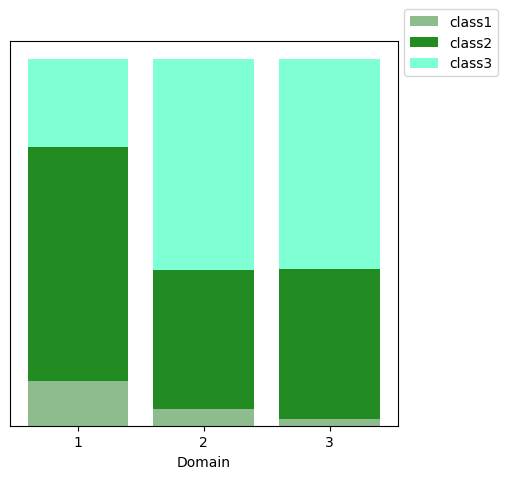

In [44]:
vec_d_counters = something_per_domain(domain, vec_d)
plot_something_per_domain_proportion(domain, vec_d, vec_d_counters, 10, legend = ['class1', 'class2', 'class3'], thres = None, title = None, digit_plot = True)

unique predicted domain [1 2 3]
unique true label [0 1 2]
unique labels [0 1 2]
[1 2 3]


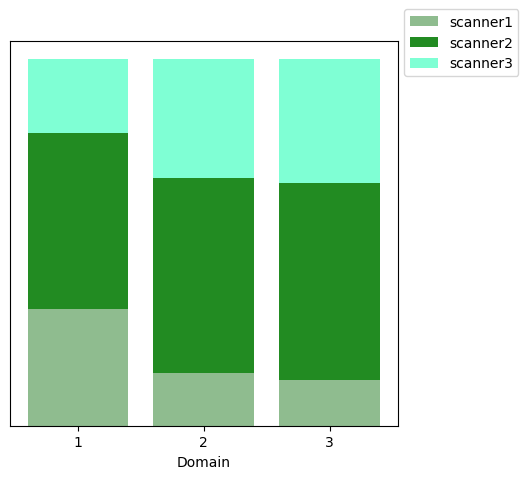

In [45]:
vec_y_counters = something_per_domain(domain, vec_y)
plot_something_per_domain_proportion(domain, vec_y, vec_y_counters, 10, legend = ['scanner1', 'scanner2', 'scanner3'], thres = None, title = None, digit_plot = True)

In [23]:
exp = mk_exp(task='her2',model='dec',trainer='cluster', train_domain ="0 1 2", test_domain="0", batchsize="4",
             dpath= '../../HER2/combined_train/', zd_dim='500', model_method ='cnn',
            prior='Gaus', pre_tr='4', epos='15', d_dim='3',lr='0.000005')

The sets of training and test domains overlap -- be aware of data leakage or training to the test!


Namespace(config_file=None, lr=5e-06, gamma_reg=0.1, es=1, seed=0, nocu=True, device=None, gen=False, keep_model=False, epos=15, epos_min=0, epo_te=1, warmup=100, debug=False, dmem=False, no_dump=False, trainer='cluster', out='zoutput', dpath='../../HER2/combined_train/', tpath=None, npath=None, npath_dom=None, npath_argna2val=None, nname_argna2val=None, nname=None, nname_dom=None, apath=None, exptag='exptag', aggtag='aggtag', bm_dir=None, plot_data=None, outp_dir='zoutput/benchmarks/shell_benchmark', param_idx=True, msel='val', model='dec', acon=None, task='her2', bs=4, split=0, te_d=['0'], tr_d=['0', '1', '2'], san_check=False, san_num=8, loglevel='DEBUG', shuffling_off=False, zd_dim=500, zx_dim=0, zy_dim=64, topic_dim=3, nname_encoder_x2topic_h=None, npath_encoder_x2topic_h=None, nname_encoder_sandwich_x2h4zd=None, npath_encoder_sandwich_x2h4zd=None, gamma_y=None, gamma_d=None, beta_t=1.0, beta_d=1.0, beta_x=1.0, beta_y=1.0, tau=0.05, epos_per_match_update=5, epochs_ctr=1, nperm=31,


using device: cpu

The sets of training and test domains overlap -- be aware of data leakage or training to the test!
/home/mariia.sidulova/domid_upgraded/DomId/DomainLab/domainlab/tasks/a_task.py:169: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(


############################################################
Pretraining initialized.
############################################################
______Created directory to save result_________





!!!: not committed yet
/home/mariia.sidulova/domid_upgraded/DomId/DomainLab/domainlab/utils/get_git_tag.py:16: UserWarning: !!!: not committed yet
  warnings.warn("!!!: not committed yet")



b'7950efa'
The sets of training and test domains overlap -- be aware of data leakage or training to the test!
/home/mariia.sidulova/domid_upgraded/DomId/DomainLab/domainlab/tasks/a_task.py:169: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(
model name: her2_te_class0_dec_b7950efa_not_commited_2024md_04md_15_11_42_22_seed_0


In [24]:
exp.execute()


 Experiment start at : 2024-04-15 11:42:34.850689
before training, model accuracy: (0.4419642857142857, array([[ 50,  89,  36],
       [115, 245, 130],
       [  3,   2,   2]]), 0.6160714285714286, array([[110,  59,   6],
       [132, 304,  54],
       [  6,   1,   0]]))
Epoch 1. Pretraining.
[0.3083536990059414, 0.3404611377189666, 0.3502843551447988, -0.3502843551447988, 0.3417890944833759, -0.35242208510036216]
[0.2811969106440373, 0.34504923528828635, 0.3368378592430721, -0.3368378592430721, 0.32291682373168, -0.3449587021840159]
epoch: 1
[-0.23895128046133324, -0.09383916655851458, -0.37468031788916994, 0.37468031788916994, -0.3425131268847443, 0.28222954291256186]
[-0.25345307623034025, -0.05658932647242264, -0.3557999437486614, 0.3557999437486614, -0.3424047212105955, 0.24618958945757388]
pooled train clustering acc (vec_d correlation):  0.45982142857142855
[[169  36  37]
 [ 67   6  77]
 [128  18 134]]
clustering validation acc:  0.42410714285714285
[[156  35  36]
 [ 71   5  88

/home/mariia.sidulova/domid_upgraded/DomId/domid/utils/storing.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(row, ignore_index=True)
/home/mariia.sidulova/domid_upgraded/DomId/domid/algos/observers/c_obvisitor_clustering.py:107: UserWarning: failed to delete model
  warnings.warn("failed to delete model")


In [25]:
dec_path = get_last_created_directory('./notebooks/')
print(dec_path)

2024-04-15_11:42:21.990399_her2_dec


In [27]:
domain, vec_d, vec_y, img_locs, model_name, command_line = load_files('./notebooks/'+dec_path)

unique predicted domain [1 2 3]
unique true label [0 1 2]
unique labels [0 1 2]
[1 2 3]


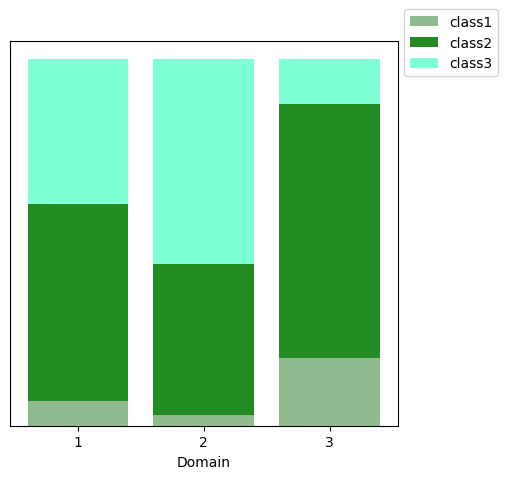

In [41]:
vec_d_counters = something_per_domain(domain, vec_d)
plot_something_per_domain_proportion(domain, vec_d, vec_d_counters, 10, legend = ['class1', 'class2', 'class3'], thres = None, title = None, digit_plot = True)

unique predicted domain [1 2 3]
unique true label [0 1 2]
unique labels [0 1 2]
[1 2 3]


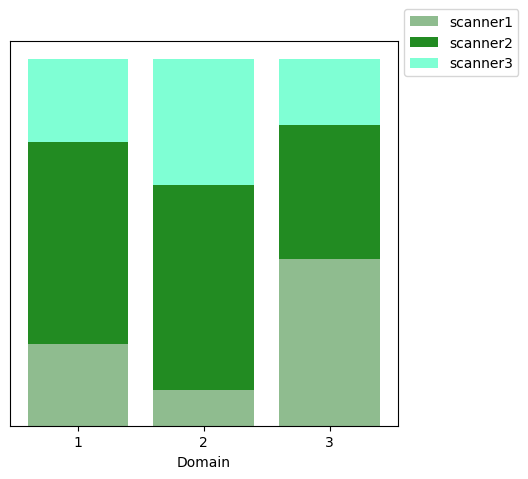

In [42]:
vec_y_counters = something_per_domain(domain, vec_y)
plot_something_per_domain_proportion(domain, vec_y, vec_y_counters, 10, legend = ['scanner1', 'scanner2', 'scanner3'], thres = None, title = None, digit_plot = True)

In [26]:
 # poetry run python main_out.py --te_d 0 --tr_d 0 1 2 --task=her2 --epos=15 --aname=vade --zd_dim=500 
 #    --d_dim=3 --apath=domid/algos/builder_vade.py --L=5 --pre_tr=4 --dpath "../../HER2/combined_train" 
 #    --bs 4 --prior Gaus --model cnn --lr 0.000005 --dim_inject_y 3 --inject_var "class"
exp = mk_exp(task='her2',model='vade',trainer='cluster', train_domain ="0 1 2", test_domain="0", batchsize="4",
             dpath= '../../HER2/combined_train/', zd_dim='500', model_method ='cnn',
            prior='Gaus', pre_tr='4', epos='15', d_dim='3',lr='0.000005', dim_inject_y=3,
             meta_data_csv = '../../HER2/combined_train/dataframe.csv',  inject_var='class', 
            )

The sets of training and test domains overlap -- be aware of data leakage or training to the test!


Namespace(config_file=None, lr=5e-06, gamma_reg=0.1, es=1, seed=0, nocu=True, device=None, gen=False, keep_model=False, epos=15, epos_min=0, epo_te=1, warmup=100, debug=False, dmem=False, no_dump=False, trainer='cluster', out='zoutput', dpath='../../HER2/combined_train/', tpath=None, npath=None, npath_dom=None, npath_argna2val=None, nname_argna2val=None, nname=None, nname_dom=None, apath=None, exptag='exptag', aggtag='aggtag', bm_dir=None, plot_data=None, outp_dir='zoutput/benchmarks/shell_benchmark', param_idx=True, msel='val', model='vade', acon=None, task='her2', bs=4, split=0, te_d=['0'], tr_d=['0', '1', '2'], san_check=False, san_num=8, loglevel='DEBUG', shuffling_off=False, zd_dim=500, zx_dim=0, zy_dim=64, topic_dim=3, nname_encoder_x2topic_h=None, npath_encoder_x2topic_h=None, nname_encoder_sandwich_x2h4zd=None, npath_encoder_sandwich_x2h4zd=None, gamma_y=None, gamma_d=None, beta_t=1.0, beta_d=1.0, beta_x=1.0, beta_y=1.0, tau=0.05, epos_per_match_update=5, epochs_ctr=1, nperm=31

/home/mariia.sidulova/domid_upgraded/DomId/DomainLab/domainlab/tasks/a_task.py:169: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(


FileNotFoundError: [Errno 2] No such file or directory: '../../HER2/combined_train/class1jpg'

In [24]:
exp.execute()


 Experiment start at : 2024-04-15 14:55:47.364324
before training, model accuracy: (0.5, array([[336, 168, 168],
       [  0,   0,   0],
       [  0,   0,   0]]), 0.5416666666666666, array([[364,  60, 248],
       [  0,   0,   0],
       [  0,   0,   0]]))
Epoch 1. Pretraining.


/home/mariia.sidulova/anaconda3/envs/domid1/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/mariia.sidulova/anaconda3/envs/domid1/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[nan, nan, nan, nan, nan, nan]


/home/mariia.sidulova/anaconda3/envs/domid1/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/mariia.sidulova/anaconda3/envs/domid1/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[nan, nan, nan, nan, nan, nan]
pi:
[0.37620223 0.06545429 0.5583435 ]
epoch: 1
[-0.014146568629736902, 0.006439935891467936, -0.02131263368711316, 0.02131263368711316, -0.016642999945033574, 0.03595306589719488]
[0.013830365429017097, -0.008764970178069558, 0.018708944465306458, -0.018708944465306465, 0.015488087807849115, -0.04112824037904103]
pooled train clustering acc (vec_d correlation):  0.47619047619047616
[[ 75  16 119]
 [  0   1   1]
 [173  43 244]]
clustering validation acc:  0.4880952380952381
[[ 86  17 122]
 [  1   0   0]
 [161  43 242]]
pooled train clustering acc (vec_y correlation):  0.4330357142857143
[[ 60  58 107]
 [  0   1   0]
 [108 109 229]]
Correlation with HER2 scores training 0.03595306589719488
Correlation with HER2 scores validation 0.018708944465306458
now:  2024-04-15 14:57:55.358478 epoch time:  0:02:07.994154 used:  0:02:07.994154
Epoch 2. Pretraining.
[0.004633918717389597, -0.0018991348517820555, 0.007250502141259288, -0.007250502141259288, 0.00553082827

/home/mariia.sidulova/domid_upgraded/DomId/domid/utils/storing.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(row, ignore_index=True)
/home/mariia.sidulova/domid_upgraded/DomId/domid/algos/observers/c_obvisitor_clustering.py:107: UserWarning: failed to delete model
  warnings.warn("failed to delete model")


# To Perform further analysys, please follow to the notebook 'HER2_box_plot_vizualization'

You will need the directories for the experiments results

Example: 

ex_dec = './notebooks/2024-04-15_11:42:21.990399_her2_dec/'

ex_vade = './notebooks/2024-04-12_13:23:14.404120_her2_vade/' 